# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tensorflow', 'keras', 'pytorch', 'deeplearning4j', 'cuda'])
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
import statistics

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gensim.downloader as api


C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Sindhoor\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

In [2]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tensorflow', 'keras', 'pytorch', 'deeplearning4j'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Reading the data

In [4]:
df = pd.read_csv(r'C:/Users\Sindhoor\Desktop\Master thesis\Dataset\Training_Test.csv',usecols =["Title", "Category"])
df

,Title,Category
0,UserWarning: Using a target size (torch.Size([...,4
1,How to free all GPU memory from pytorch.load?,3
2,PyTorch gives incorrect results due to broadca...,4
3,How to install keras 2.0.5 version in a conda ...,0
4,How can I do the mean of n tensors? Sum them a...,2
...,...,...
904,How to migrate Tensorflow 1.x class to Tensorf...,5
905,Migrating to Tensorflow 2.x from 1.x results i...,5
906,How to migrate from keras.engine.[...] to tf.k...,5
907,Tensorflow port model from 1.x to 2.x,5


# Data Preprocessing

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Title.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['userwarning', 'using', 'target', 'size', 'torch', 'size', 'that', 'is', 'different', 'to', 'the', 'input', 'size', 'torch', 'size']]


In [6]:
import spacy
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN', 'NUM', 'SCONJ']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]     
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [7]:
data = pd.DataFrame(({0: data_ready, 1: df.Title.values, 3: df.Category.values }))
data.columns = ['Text_Tokenized', 'Title', 'Category']
data

,Text_Tokenized,Title,Category
0,"[userwarne, use, target, size, torch, size, di...",UserWarning: Using a target size (torch.Size([...,4
1,"[free, gpu, memory, load]",How to free all GPU memory from pytorch.load?,3
2,"[give, incorrect, result, due, broadcast]",PyTorch gives incorrect results due to broadca...,4
3,"[install, version, conda, environment]",How to install keras 2.0.5 version in a conda ...,0
4,"[mean, tensor, sum, divide, result, get, tenso...",How can I do the mean of n tensors? Sum them a...,2
...,...,...,...
904,"[migrate, class]",How to migrate Tensorflow 1.x class to Tensorf...,5
905,"[migrate, result, much, slow, training, google...",Migrating to Tensorflow 2.x from 1.x results i...,5
906,"[migrate, engine, engine]",How to migrate from keras.engine.[...] to tf.k...,5
907,"[port, model]",Tensorflow port model from 1.x to 2.x,5


# word2vec Model Building

In [8]:
from sklearn import preprocessing

In [9]:
vector_size_n_w2v = 85

w2v_model = Word2Vec(data['Text_Tokenized'],
                     vector_size=vector_size_n_w2v,
                     window=3,
                     min_count=1,
                     sg=0, # 0=CBOW, 1=Skip-gram
                     epochs=10)

print(w2v_model)

Word2Vec<vocab=1298, vector_size=85, alpha=0.025>


In [10]:
w2v_model.save(".\\word2vec\\word2vec_model")

pk.dump(vector_size_n_w2v, open(".\\word2vec\\vector_size_w2v_metric.pkl", 'wb'))

In [11]:
words = set(w2v_model.wv.index_to_key)
data['Text_vect'] = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in data['Text_Tokenized']])

C:\Users\Sindhoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
data.to_excel("test_output.xlsx", index=False)
for i, v in enumerate(data['Text_vect']):
    print(len(data['Text_Tokenized'].iloc[i]), len(v))

11 11
4 4
5 5
4 4
8 8
5 5
7 7
5 5
7 7
6 6
5 5
5 5
11 11
7 7
5 5
6 6
4 4
3 3
6 6
8 8
7 7
8 8
7 7
11 11
5 5
4 4
6 6
12 12
4 4
9 9
6 6
9 9
9 9
9 9
5 5
9 9
5 5
8 8
8 8
8 8
7 7
3 3
6 6
6 6
8 8
3 3
7 7
6 6
9 9
2 2
4 4
5 5
3 3
5 5
11 11
4 4
9 9
3 3
4 4
7 7
8 8
2 2
2 2
9 9
5 5
5 5
7 7
4 4
3 3
8 8
9 9
12 12
4 4
10 10
6 6
2 2
4 4
8 8
11 11
8 8
3 3
8 8
5 5
6 6
4 4
8 8
8 8
9 9
4 4
8 8
9 9
4 4
5 5
4 4
7 7
5 5
11 11
10 10
5 5
6 6
6 6
7 7
10 10
6 6
5 5
6 6
7 7
4 4
5 5
2 2
10 10
7 7
10 10
5 5
9 9
4 4
7 7
6 6
3 3
6 6
3 3
2 2
3 3
4 4
7 7
4 4
8 8
3 3
6 6
4 4
11 11
11 11
9 9
3 3
4 4
3 3
6 6
8 8
8 8
6 6
6 6
3 3
8 8
7 7
7 7
5 5
9 9
5 5
5 5
4 4
5 5
7 7
5 5
4 4
6 6
7 7
7 7
6 6
5 5
3 3
7 7
9 9
6 6
4 4
6 6
6 6
7 7
6 6
7 7
3 3
6 6
4 4
12 12
2 2
3 3
3 3
6 6
6 6
10 10
8 8
8 8
7 7
8 8
3 3
9 9
3 3
3 3
7 7
9 9
2 2
5 5
5 5
9 9
5 5
4 4
6 6
9 9
6 6
8 8
6 6
7 7
5 5
7 7
6 6
4 4
3 3
9 9
5 5
8 8
4 4
5 5
12 12
7 7
4 4
6 6
6 6
5 5
4 4
4 4
10 10
7 7
7 7
8 8
7 7
6 6
3 3
7 7
5 5
7 7
3 3
7 7
5 5
11 11
5 5
7 7
7 7
3 3
5 5
8 8
3 3


# Creating average vectors to avoid shape inconsistency

In [13]:
content_sentence1_Text_vect = list(data['Text_vect'].loc[0:0])
text_vect_avg = []
for v in data['Text_vect']:
    if v.size:
        text_vect_avg.append(v.mean(axis=0))
    else:
        text_vect_avg.append(np.zeros(vector_size_n, dtype=float)) # the same vector size must be used here as for model training
        
        
data['Text_vect_avg'] = text_vect_avg

In [14]:
df_Machine_Learning = pd.DataFrame(text_vect_avg)

In [15]:
df_Machine_Learning.columns = ['Element_' + str(i+1) for i in range(0, df_Machine_Learning.shape[1])]

In [16]:
X=w2v_model.wv.index_to_key
df=pd.DataFrame(df_Machine_Learning)
df.shape
df.head()

,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,Element_9,Element_10,...,Element_76,Element_77,Element_78,Element_79,Element_80,Element_81,Element_82,Element_83,Element_84,Element_85
0,0.001333,-0.003229,-0.014151,0.002065,0.029641,-0.008052,-0.004654,0.012692,-0.005385,0.003727,...,-0.011384,0.015869,0.005542,-0.024710,-0.013638,0.036702,0.008778,-0.017854,-0.003916,0.001162
1,-0.000586,-0.005690,-0.013165,-0.000036,0.029916,-0.014113,-0.009178,0.005401,-0.006992,-0.006455,...,-0.010830,0.012485,0.008975,-0.016691,-0.006365,0.039919,0.015919,-0.017971,-0.015594,-0.000777
2,-0.002577,-0.003655,-0.002509,-0.001850,0.013248,-0.000930,-0.001716,0.000112,-0.008866,0.000033,...,0.000776,0.002011,0.004357,-0.005098,-0.001097,0.019933,-0.000435,-0.005924,0.001903,0.000020
3,0.004808,-0.004246,-0.016861,0.002390,0.027076,-0.010249,-0.008326,0.014012,-0.005732,-0.004115,...,-0.001233,0.005570,0.011546,-0.019576,-0.006694,0.027527,0.012445,-0.010270,-0.009218,-0.004570
4,0.003960,-0.005483,-0.010573,-0.000581,0.026760,-0.001798,-0.003896,0.007971,-0.010312,0.000049,...,-0.011875,0.012205,0.008761,-0.019400,-0.006385,0.034606,0.006878,-0.003409,-0.006280,0.001602


# Final data frame after the implementation of word2vec

In [19]:
final_df = pd.concat([data[['Title', 'Category']], df_Machine_Learning], axis=1, sort=False)
final_df

,Title,Category,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,...,Element_76,Element_77,Element_78,Element_79,Element_80,Element_81,Element_82,Element_83,Element_84,Element_85
0,UserWarning: Using a target size (torch.Size([...,4,0.001333,-0.003229,-0.014151,0.002065,0.029641,-0.008052,-0.004654,0.012692,...,-0.011384,0.015869,0.005542,-0.024710,-0.013638,0.036702,0.008778,-0.017854,-0.003916,0.001162
1,How to free all GPU memory from pytorch.load?,3,-0.000586,-0.005690,-0.013165,-0.000036,0.029916,-0.014113,-0.009178,0.005401,...,-0.010830,0.012485,0.008975,-0.016691,-0.006365,0.039919,0.015919,-0.017971,-0.015594,-0.000777
2,PyTorch gives incorrect results due to broadca...,4,-0.002577,-0.003655,-0.002509,-0.001850,0.013248,-0.000930,-0.001716,0.000112,...,0.000776,0.002011,0.004357,-0.005098,-0.001097,0.019933,-0.000435,-0.005924,0.001903,0.000020
3,How to install keras 2.0.5 version in a conda ...,0,0.004808,-0.004246,-0.016861,0.002390,0.027076,-0.010249,-0.008326,0.014012,...,-0.001233,0.005570,0.011546,-0.019576,-0.006694,0.027527,0.012445,-0.010270,-0.009218,-0.004570
4,How can I do the mean of n tensors? Sum them a...,2,0.003960,-0.005483,-0.010573,-0.000581,0.026760,-0.001798,-0.003896,0.007971,...,-0.011875,0.012205,0.008761,-0.019400,-0.006385,0.034606,0.006878,-0.003409,-0.006280,0.001602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,How to migrate Tensorflow 1.x class to Tensorf...,5,0.004230,-0.004539,-0.015723,0.009002,0.024081,-0.010289,-0.011752,0.004848,...,-0.005518,0.005527,0.004990,-0.013093,-0.000238,0.018722,0.013006,-0.007881,-0.001025,0.001252
905,Migrating to Tensorflow 2.x from 1.x results i...,5,-0.004925,-0.003401,-0.008701,-0.001544,0.017236,-0.004682,-0.004260,0.007648,...,-0.003785,0.006674,0.007233,-0.013040,-0.004325,0.025136,0.009653,-0.007193,-0.005594,-0.001101
906,How to migrate from keras.engine.[...] to tf.k...,5,-0.000286,0.006111,-0.014066,0.002460,0.012821,-0.011210,0.002498,0.004478,...,0.003568,0.004560,-0.004338,0.001060,0.004426,0.008223,0.001069,-0.010608,-0.007176,-0.003944
907,Tensorflow port model from 1.x to 2.x,5,-0.002792,-0.001285,-0.007986,0.005414,0.022368,-0.016462,-0.007805,0.018372,...,-0.004886,0.013241,0.009717,-0.026112,-0.011631,0.040686,0.011673,-0.004754,-0.005032,-0.009348


In [20]:
XX = final_df.loc[:, final_df.columns != 'Category']
X = XX.loc[:, XX.columns != 'Title']
#X = final_df[['Element_1', 'Element_2', 'Element_3', 'Element_4', 'Element_5', 'Element_6', 'Element_7',
                                                             #'Element_8', 'Element_9', 'Element_10']]
Y = final_df['Category']

In [62]:
import multiprocessing
from sklearn.manifold import TSNE

In [54]:
vocab=list(w2v_model.wv.index_to_key)
embedding_clusters = []
word_clusters = []
for word in vocab:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [57]:
vocab=list(w2v_model.wv.index_to_key)
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
% matplotlib inline

UsageError: Line magic function `%` not found.


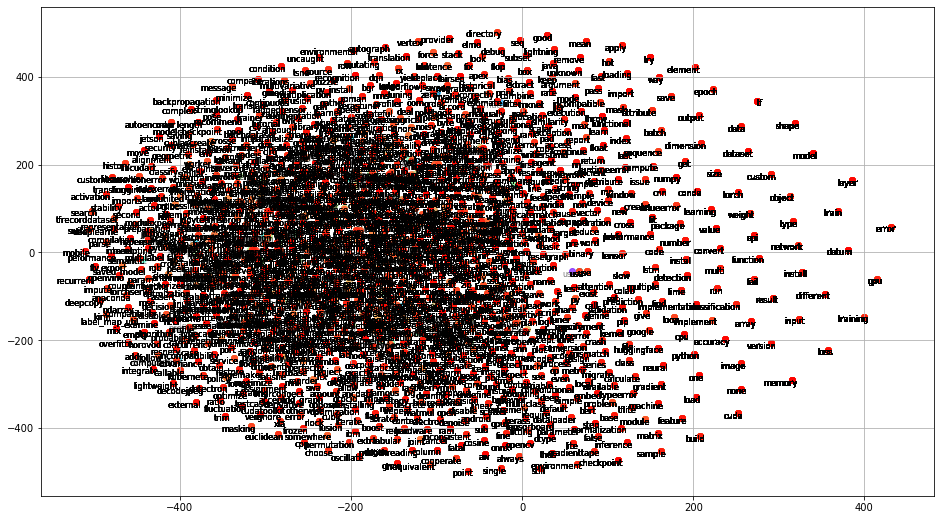

In [61]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='top', size=8)
    #plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("C:/Users\Sindhoor\Desktop\Master thesis\Output\г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(vocab, embeddings_en_2d, word_clusters)

# SVM model building

In [47]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=200) # 80% training and 30% test


In [22]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma=8, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) # RBF Kernel


#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_train)
y_pred_1 = clf.predict(X_test)




# Performance evaluation

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred_1)
cm
Accuracy = accuracy_score(y_test, y_pred_1)
Accuracy

0.7307692307692307

C:\Users\Sindhoor\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


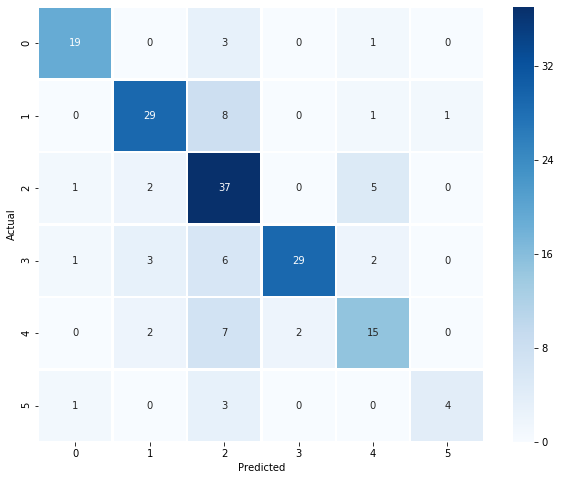

In [24]:
# plot confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))         
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=1.5, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Data visualization

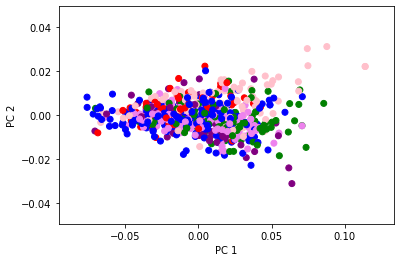

In [25]:
# reduce data to 2 dimensions using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# predict classes for reduced data
y_pca = clf.predict(X_train)

new1 = y_train.to_frame()
color_codes = {0: 'red', 1: 'green', 2: 'blue', 3:'pink', 4:'violet',
               5:'purple'}
new1['color'] = new1['Category'].map(color_codes)
new1['color']
# plot reduced data on a scatter plot, colored by predicted class
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = new1['color'], cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [26]:
support_vector_indices = clf.support_
support_vectors_per_class = clf.n_support_
print(support_vectors_per_class)

[ 55 100 186  87 108  51]


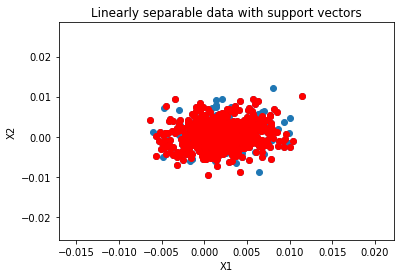

In [27]:
import matplotlib.pyplot as plt

# plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], color="b", s=50, cmap='autumn')
# Get support vectors themselves
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,3])
plt.scatter(support_vectors[:,0], support_vectors[:,3], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [29]:
X1_sepal = X.iloc[:,[0,1]]
X2_petal = X.iloc[:,[2,3]]
X3_sepal = X.iloc[:,[4,5]]
X4_petal = X.iloc[:,[6,7]]
X4_sepal = X.iloc[:,[8,9]]
X4_petal = X.iloc[:,[10,11]]
y = Y

print(X1_sepal.iloc[1:5,:])
print(X2_petal.iloc[1:5,:])

   Element_1  Element_2
1  -0.000586  -0.005690
2  -0.002577  -0.003655
3   0.004808  -0.004246
4   0.003960  -0.005483
   Element_3  Element_4
1  -0.013165  -0.000036
2  -0.002509  -0.001850
3  -0.016861   0.002390
4  -0.010573  -0.000581


In [30]:
colornames = Y.to_frame()
color_codes = {0: 'red', 1: 'green', 2: 'blue', 3:'pink', 4:'violet',
               5:'purple'}
colornames['color'] = colornames['Category'].map(color_codes)
colornames['color']

0      violet
1        pink
2      violet
3         red
4        blue
        ...  
904    purple
905    purple
906    purple
907    purple
908    purple
Name: color, Length: 909, dtype: object

Text(0, 0.5, 'PC2')

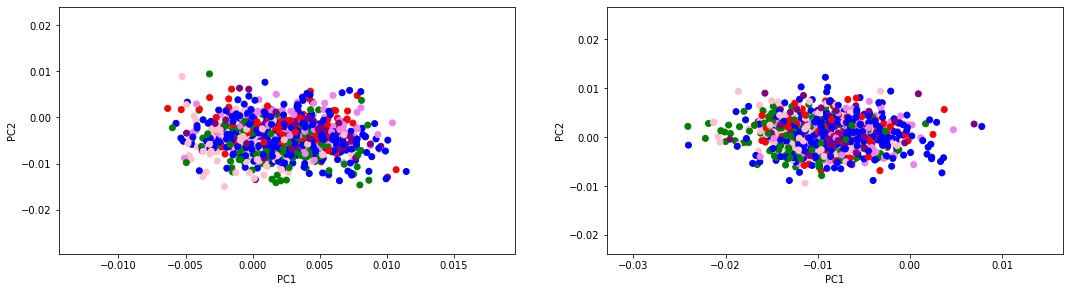

In [34]:
plt.figure(figsize=(18, 10))

plt.subplot(2,2,1)
plt.scatter(X1_sepal.iloc[:, 0], X1_sepal.iloc[:, 1], c=colornames['color'])
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(2,2,2)
plt.scatter(X2_petal.iloc[:, 0], X2_petal.iloc[:, 1], c=colornames['color'])
plt.xlabel('PC1')
plt.ylabel('PC2')


In [35]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    
    # Initialise the marker types and colors
    markers = ('s','x','o','^','v', '4')
    colors = ('red','blue','lightgreen','gray','cyan','pink')
    color_Map = ListedColormap(colors[:len(np.unique(y))]) #we take the color mapping correspoding to the 
        # Parameters for the graph and decision surface
    x1_min = X[:,0].min() - 1
    x1_max = X[:,0].max() + 1
    x2_min = X[:,1].min() - 1
    x2_max = X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contour(xx1,xx2,Z,alpha=0.4,cmap = color_Map)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # Plot samples
    X_test, Y_test = X[test_idx,:], y[test_idx]
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha = 0.8, c = color_Map(idx),
                    marker = markers[idx], label = cl
                   )

In [36]:
from sklearn.preprocessing import StandardScaler

#######################################################################
## SPLITTING


X_train_sepal, X_test_sepal, y_train_sepal, y_test_sepal = train_test_split(X1_sepal,y,test_size=0.1,random_state=0)

print("# training samples sepal: ", len(X_train_sepal))
print("# testing samples sepal: ", len(X_test_sepal))

X_train_petal, X_test_petal, y_train_petal, y_test_petal = train_test_split(X2_petal,y,test_size=0.1,random_state=0)

print("# training samples petal: ", len(X_train_petal))
print("# testing samples petal: ", len(X_test_petal))

#####################################################################
## SCALING

sc = StandardScaler()
X_train_sepal_std = sc.fit_transform(X_train_sepal)
X_test_sepal_std = sc.transform(X_test_sepal)

sc = StandardScaler()
X_train_petal_std = sc.fit_transform(X_train_petal)
X_test_petal_std = sc.transform(X_test_petal)

#####################################################################
## COMBINING FOR FUTURE PLOTTING

X_combined_sepal_standard = np.vstack((X_train_sepal_std,X_test_sepal_std))
Y_combined_sepal = np.hstack((y_train_sepal, y_test_sepal))

X_combined_petal_standard = np.vstack((X_train_petal_std,X_test_petal_std))
Y_combined_petal = np.hstack((y_train_petal, y_test_petal))

# training samples sepal:  818
# testing samples sepal:  91
# training samples petal:  818
# testing samples petal:  91


   degree  Accuracy
0      10  0.318681


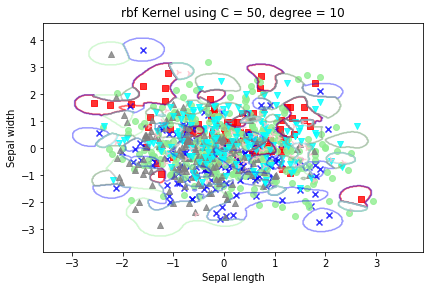

In [37]:
rbf_degree_range = [10]

sepal_acc_table = pd.DataFrame(columns = ['degree','Accuracy'])
sepal_acc_table['degree'] = rbf_degree_range

plt.figure(figsize=(15, 16))

j = 0

for i in rbf_degree_range:
    
    # Apply SVM model to training data
    svm_rbf =  SVC(kernel = 'rbf', degree = i, C = 10, gamma =6, random_state = 0)
    svm_rbf.fit(X_train_sepal_std,y_train_sepal)
    
    # Predict using model
    y_pred_sepal = svm_rbf.predict(X_test_sepal_std)
    
    # Saving accuracy score in table
    sepal_acc_table.iloc[j,1] = accuracy_score(y_test_sepal,y_pred_sepal)
    j += 1
    
    # Printing decision regions
    plt.subplot(3,2,j)
    plt.subplots_adjust(hspace = 0.4)
    plot_decision_regions(X = X_combined_sepal_standard
                      , y = Y_combined_sepal
                      , classifier = svm_rbf
                      )
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title('rbf Kernel using C = 50, degree = %s'%i)
    
print(sepal_acc_table)

In [38]:
from scikitplot.metrics import plot_roc_curve

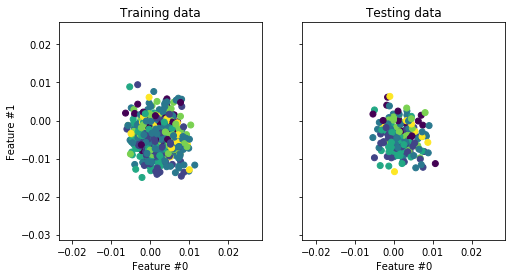

In [39]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [40]:
w2v_model.wv.most_similar('model')

[('error', 0.9219246506690979),
 ('layer', 0.9065069556236267),
 ('use', 0.9019107818603516),
 ('gpu', 0.9010030031204224),
 ('datum', 0.8967425227165222),
 ('input', 0.8922818899154663),
 ('train', 0.8889232277870178),
 ('tensor', 0.8865278363227844),
 ('install', 0.8828530311584473),
 ('training', 0.8825244903564453)]

In [41]:
from sklearn.metrics import roc_curve, auc

# Checking best performance for different parameters

In [42]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [40, 45, 50, 55, 60],
              'degree': [5, 6, 7, 8, 9],
              'gamma':[1, 2, 3, 4, 5, 6, 7, 8],
              'kernel': ['rbf']
              }        
cl = svm.SVC()
grid = GridSearchCV(cl, parameters, cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
from sklearn.metrics import classification_report
grid_prediction = grid.predict(X_test)
print(classification_report(y_test, grid_prediction))

{'C': 60, 'degree': 5, 'gamma': 7, 'kernel': 'rbf'}
SVC(C=60, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma=7, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        23
           1       0.81      0.74      0.77        39
           2       0.57      0.80      0.67        45
           3       0.94      0.71      0.81        41
           4       0.60      0.58      0.59        26
           5       0.80      0.50      0.62         8

    accuracy                           0.73       182
   macro avg       0.76      0.69      0.72       182
weighted avg       0.75      0.73      0.73       182



# Prediction for new data sample

In [43]:
pk.dump(clf, open('clf_model.pkl', 'wb'))

In [44]:
w2v_model_reloaded = Word2Vec.load("word2vec/word2vec_model")
vector_size_n_reloaded = pk.load(open("word2vec/vector_size_w2v_metric.pkl",'rb'))

print(w2v_model_reloaded)
print(vector_size_n_reloaded)

Word2Vec<vocab=1298, vector_size=85, alpha=0.025>
85


In [45]:
new_input = ["Converting code in keras to other frameworks", 
             "how to install pytorch?",
             "shaping tf Data as input for LSTM layer fails with incompatible dimensions",
             "How can I convert a tensor into a numpy array in TensorFlow?",
             "How to free all GPU memory from pytorch load?",
             "synchronous distributed training is slow"]
 
print(new_input[0])
print(new_input[1])

Converting code in keras to other frameworks
how to install pytorch?


In [50]:
new_input_df = y_test.to_frame()
new_input_df2 = pd.DataFrame(y_pred_1)

df_new = pd.concat([new_input_df.reset_index(drop=True),new_input_df2.reset_index(drop=True)], axis=1)